In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip

In [2]:
# # random seed
# SEED = 1 
# NUM_CLASS = 10

# Training
BATCH_SIZE = 128
# NUM_EPOCHS = 30
# EVAL_INTERVAL=1
# SAVE_DIR = './log'

# # Optimizer
# LEARNING_RATE = 1e-1
# MOMENTUM = 0.9
# STEP=5
# GAMMA=0.5

# CLIP
VISUAL_BACKBONE = 'RN50' # RN50, ViT-B/32, ViT-B/16


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
transform_FM_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_set = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform_FM_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
dataset_name = 'FashionMNIST'

In [12]:
# Load the model
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
model.to(device)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [13]:

def prompt_encode(prompt):
    """
    Args:
        prompt (str): the text prefix before the class

    Returns:
        text_inputs(torch.Tensor)

    """
    ##################### Write your answer here ##################
    text_inputs = clip.tokenize(prompt).to(device)
    ###############################################################
    
    return text_inputs
prompt = 'a photo of a bag' # you can try different prompt
text_inputs = prompt_encode(prompt)
text_inputs

tensor([[49406,   320,  1125,   539,   320,  3365, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0',
       dtype=torch.int32)

In [14]:
def model_inference(model, image, text_inputs):
    """
    Perform model inference to calculate logits for zero-shot learning.

    Args:
        model (CLIPModel): The CLIP model for inference.
        image (torch.Tensor): The batch of images to encode.
        text_inputs (torch.Tensor): The batch of text inputs to encode.

    Returns:
        torch.Tensor: Logits representing the similarity between images and texts.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Encode the image using the CLIP model
    with torch.no_grad():
        image_features = model.encode_image(image)

    # Normalize the image features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Encode the text using the CLIP model's text encoder
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)

    # Normalize the text features
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Calculate the similarity (logits) between each image and text
    logits = image_features @ text_features.t()

    return logits


In [21]:
testing_loss = []
testing_acc = []
criterion = nn.CrossEntropyLoss()
all_predictions = []
all_labels = []

with torch.no_grad():
    model.eval()

    correct_predictions = 0
    total_predictions = 0

    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # 模型推理
        logits = model_inference(model, images, text_inputs)

        # 计算损失
        loss = criterion(logits, labels)
        testing_loss.append(loss.item())

        # 计算预测
        predictions = logits.argmax(dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 计算准确率
val_acc = correct_predictions / total_predictions
avg_loss = sum(testing_loss) / len(testing_loss)

print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, average loss: {avg_loss:.2f}, visual encoder is {VISUAL_BACKBONE}.")


the zero-shot performance on FashionMNIST is 27.81%, average loss: 2.29, visual encoder is RN50.


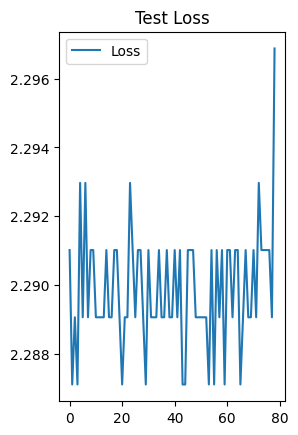

In [22]:

plt.subplot(1, 2, 2)
plt.plot(testing_loss, label='Loss')
plt.title('Test Loss')
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


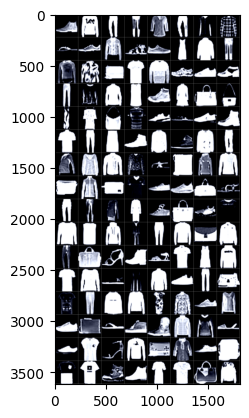

GroundTruth:  Ankle boot Pullover Trouser Trouser Shirt Trouser Coat Shirt Sandal Sneaker Coat Sandal Sneaker Dress Coat Trouser Pullover Coat Bag T-shirt/top Pullover Sandal Sneaker Ankle boot Trouser Coat Shirt T-shirt/top Ankle boot Dress Bag Bag Dress Dress Bag T-shirt/top Sneaker Sandal Sneaker Ankle boot Shirt Trouser Dress Sneaker Shirt Sneaker Pullover Trouser Pullover Pullover Coat Coat Sandal Bag Pullover Pullover Bag Coat Bag T-shirt/top Sneaker Sneaker Bag Sandal Trouser Trouser Pullover Dress Ankle boot Bag Sneaker T-shirt/top Pullover Shirt Pullover Dress Trouser Pullover Bag Coat Trouser Bag Sandal Ankle boot Sandal T-shirt/top Dress Pullover T-shirt/top Shirt Sandal Dress Shirt Sneaker Trouser Bag T-shirt/top Trouser Coat Pullover Dress Shirt Sneaker Pullover Sneaker Bag Sandal Ankle boot Ankle boot Coat Pullover Sandal Sneaker T-shirt/top Sandal Pullover Bag Shirt Sneaker Bag T-shirt/top T-shirt/top Ankle boot Ankle boot Dress T-shirt/top Bag Coat


In [20]:
# 获取一些随机测试图片
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# 展示图片
imshow(torchvision.utils.make_grid(images))

# 打印标签
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]}' for j in range(len(labels))))


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


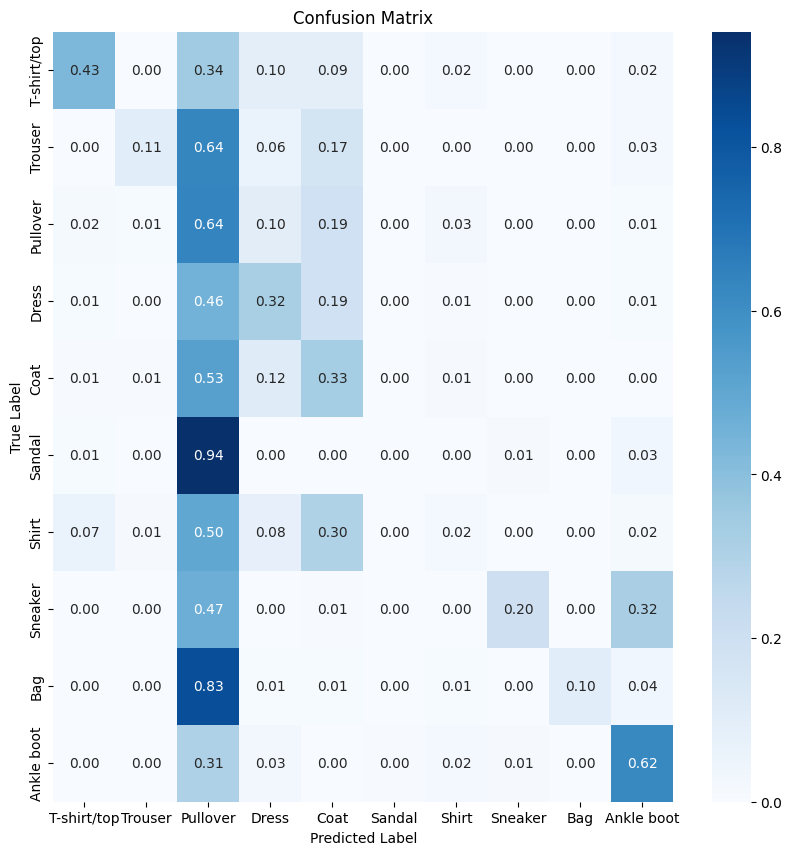

In [26]:
# 创建混淆矩阵
cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化

# 可视化混淆矩阵
plt.figure(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
